# Setup

## Imports

In [10]:
from vaiutils import path_consts, plot_images, read_mnist_data, plot_image

In [6]:
import tensorflow as tf

## Setup data and variables

In [4]:
data, _ = read_mnist_data()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


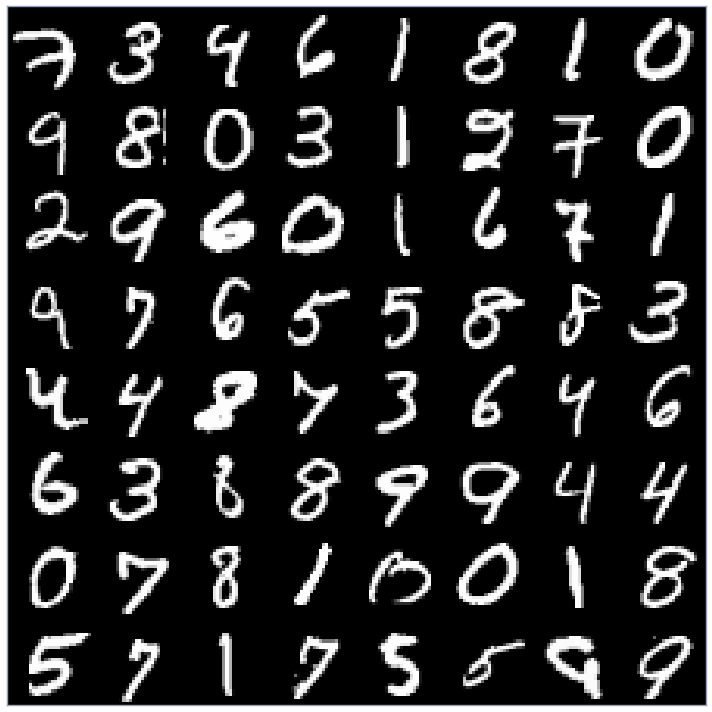

In [5]:
plot_images(data.train.images[:64])

In [8]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak * x)

# Create Model

## Define functions

In [86]:
c_dim = 100
z_dim = 32

In [83]:
def see_image(img, training):
    c = tf.layers.conv2d(img, 32, (5, 5), strides=(
        1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv1')
    c = lrelu(c, 0.2, 'lrelu1')

    c = tf.layers.conv2d(c, 64, (5, 5), strides=(
        1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv2')
    c = tf.contrib.layers.batch_norm(
        c, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    c = lrelu(c, 0.2, 'lrelu2')

    c = tf.layers.conv2d(c, 128, (5, 5), strides=(
        2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv3')
    c = tf.contrib.layers.batch_norm(
        c, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    c = lrelu(c, 0.2, 'lrelu3')

    c = tf.layers.conv2d(c, 256, (5, 5), strides=(
        2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv4')
    c = tf.contrib.layers.batch_norm(
        c, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    c = lrelu(c, 0.2, 'lrelu4')

    c = tf.reshape(c, (-1, 7 * 7 * 256))
    return tf.layers.dense(c, z_dim, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')

In [84]:
def discriminator(c):
    return tf.layers.dense(c, 1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')

In [87]:
def draw_image(c, z):
    start_pos = tf.layers.dense(tf.concat([c, z], axis=1), 2, kernel_initializer=tf.random_normal_initializer(
        stddev=0.02), activation=tf.nn.sigmoid, name='fc1')
    end_pos = tf.layers.dense(c, 2, kernel_initializer=tf.random_normal_initializer(
        stddev=0.02), activation=tf.nn.sigmoid, name='fc2')
    return start_pos, end_pos

## Define Graph

In [94]:
tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    x_fake = tf.placeholder(tf.float32, (None, 784), 'x_fake')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    training = tf.placeholder_with_default(True, [], 'training')
    l_g_prev = tf.placeholder(tf.float32, (None, 1), 'l_g_prev')

    x_image = tf.reshape(x, (-1, 28, 28, 1), 'x_image')
    x_fake_image = tf.reshape(x_fake, (-1, 28, 28, 1), 'x_fake_image')

with tf.variable_scope('vision'):
    c_real = see_image(x_image, training)
    tf.get_variable_scope().reuse_variables()
    c_fake = see_image(x_fake_image, training)

with tf.variable_scope('discriminator'):
    l_x = discriminator(c_real)
    tf.get_variable_scope().reuse_variables()
    l_g = discriminator(c_fake)

with tf.variable_scope('hands'):
    start_pos, end_pos = draw_image(c_fake, z)

with tf.name_scope('optimizer'):
    loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_x, labels=tf.ones_like(
        l_x))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.zeros_like(l_g)))
    optimizer_d = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_d = optimizer_d.compute_gradients(loss_d, var_list=tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vision'))
    optimize_d = optimizer_d.apply_gradients(grads_d)

    optimizer_g = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_g = optimizer_g.compute_gradients(tf.nn.sigmoid(l_g) / tf.nn.sigmoid(l_g_prev), var_list=tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, 'hands'))
    optimize_g = optimizer_g.apply_gradients(grads_g)

tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
add_variable_histogram_summaries()

'''for g_v_pair in grads_g:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])

for g_v_pair in grads_d:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])'''

summ = tf.summary.merge_all()

saver = tf.train.Saver()

ValueError: No gradients provided for any variable: ['<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7ffa7d263e80>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7ffa7c65aac8>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7ffa7c65abe0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7ffa7c65a9e8>'].

# Experiment

In [21]:
def draw_line(img, start, end, points=None):
    if points is None:
        points = max(abs(end[1] - start[1]), abs(end[0] - start[0]))

    xs = np.linspace(start[0], end[0], points).astype('uint8')
    ys = np.linspace(start[1], end[1], points).astype('uint8')

    img[xs, ys] = 1

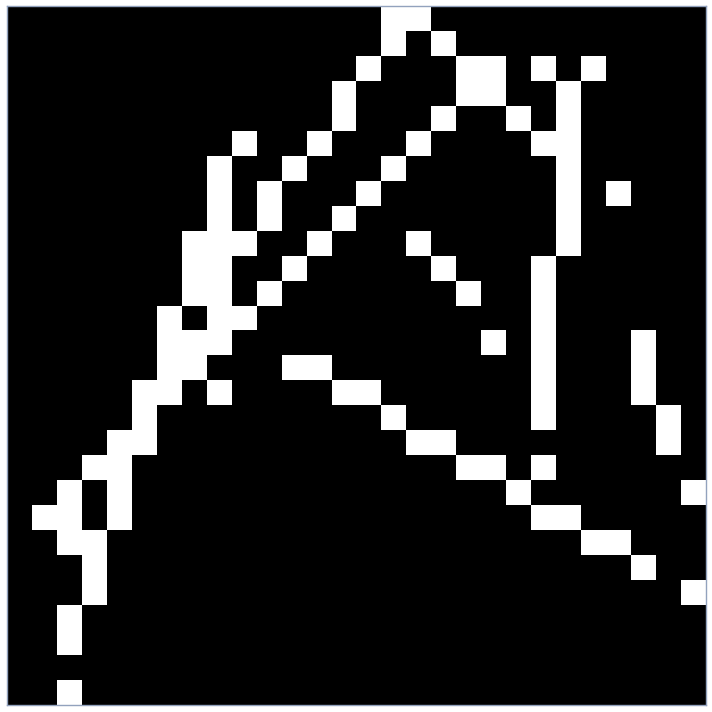

In [76]:
img = np.zeros((28, 28))
for _ in range(10):
    rand_x1, rand_y1, rand_x2, rand_y2 = randint(
        0, 28), randint(0, 28), randint(0, 28), randint(0, 28)
    draw_line(img, (rand_x1, rand_y1), (rand_x2, rand_y2))
plot_image(img)